In [1]:
from fears.utils import AutoRate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import scipy.interpolate as interp
import scipy.optimize as sciopt
import pickle

In [2]:
# get the cell-count vs od data first

od_path = '../calibration_data/calibration_05172023/EK_single_OD600_20230517_154009_no_lid.xlsx'
p_od = AutoRate.Plate(od_path,mode='single_measurement')
od_data = p_od.od_data_to_dict(p_od.data)

cell_count_raw = np.zeros((3,4))

# experimentally observed cell count valies
cell_count_raw[:,0] = [163,322,194] 
cell_count_raw[:,1] = [74,70,72]
cell_count_raw[:,2] = [22,11,15]
cell_count_raw[:,3] = [4,9,6]

cell_count_raw = (cell_count_raw*10**5)/50

cell_count_avg = np.mean(cell_count_raw,axis=0)
cell_count_std = np.std(cell_count_raw,axis=0)
cell_count_err = cell_count_std/np.sqrt(3)

cell_count_plate_streak = cell_count_avg
cell_count_plate_streak_err = cell_count_err

# background subtract od data

row_list = ['A','B','C','D','E','F','G','H']
bg_cols = [1,12]
bg_cols = [str(c) for c in bg_cols]

bg_est = 0
indx = 0
for row in row_list:
    for col in bg_cols:
        key = row + col
        bg_est += od_data[key]
        indx+=1

bg_est = bg_est/indx

col_list = np.arange(12) + 1
col_list = [str(c) for c in col_list]

od_t = np.zeros((len(row_list)-2,len(col_list)-2))
row_indx = 0
for row in row_list[1:-1]:
    col_indx = 0
    for col in col_list[1:-1]:
        key = row+col
        # od_data[key] = od_data[key] - bg_est
        od_t[row_indx,col_indx] = od_data[key] -  bg_est
        col_indx += 1

    row_indx += 1

Text(0.05, 0.6, 'Intercept: 13.53')

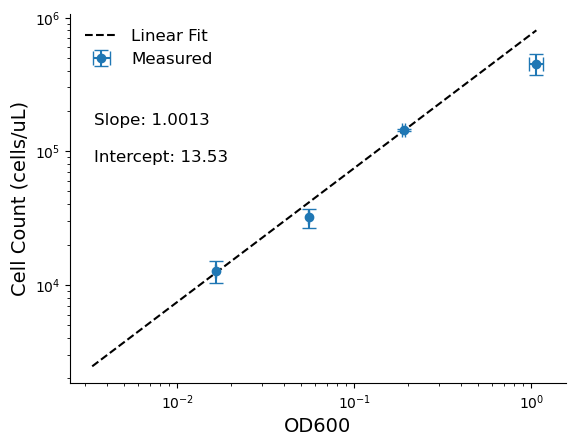

In [3]:
od_avg = np.mean(od_t,axis=0)
od_std = np.std(od_t,axis=0)
od_err = od_std/np.sqrt(len(row_list)-2)

od_measured = od_avg[[0,2,4,6]] 
od_measured_err = od_err[[0,2,4,6]] 

# plot OD vs cell count

fig,ax = plt.subplots()

ax.errorbar(od_measured,cell_count_avg,yerr=cell_count_err,xerr=od_measured_err,
            fmt='o',capsize=5,label='Measured')
ax.set_yscale('log')
ax.set_xscale('log')

# extrapolate OD data

dilution = []
for i in range(len(col_list)-2):
    dilution.append(1/(2**i))

dilution = np.array(dilution)
cell_count_extrap = dilution*cell_count_avg[0]

# fit a linear model to log-log data

def linear(x,m,b):
    return m*x + b

xdata = np.log(od_measured)

popt,pcov = sciopt.curve_fit(linear,np.log(od_measured),np.log(cell_count_avg),sigma=cell_count_err/np.log(cell_count_avg),absolute_sigma=True)

m = popt[0]
b = popt[1]

xfit_odvc = np.linspace(np.min(od_avg),np.max(od_avg),100)
yfit_odvc = np.exp(linear(np.log(xfit_odvc),m,b))

ax.plot(xfit_odvc,yfit_odvc,'k--',label='Linear Fit')

ax.set_xlabel('OD600',fontsize=14)
ax.set_ylabel('Cell Count (cells/uL)',fontsize=14)

ax.legend(fontsize=12,frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# annotate slope and intercept
ax.annotate('Slope: {:.4f}'.format(m),xy=(0.05,0.7),xycoords='axes fraction',fontsize=12)
ax.annotate('Intercept: {:.2f}'.format(b),xy=(0.05,0.6),xycoords='axes fraction',fontsize=12)

In [4]:
ab_plate_path = '../calibration_data/calibration_08302023/EK_single_AB_constant_gain_20230830_122655.xlsx'
od_plate_path = '../calibration_data/calibration_08302023/EK_single_OD600_20230830_114542.xlsx'
p_ab = AutoRate.Plate(ab_plate_path,mode='single_measurement')
p_od = AutoRate.Plate(od_plate_path,mode='single_measurement')
od_data = p_od.od_data_to_dict(p_od.data)

In [5]:
# estimate od background

row_list = ['A','B','C','D','E','F','G','H']
bg_cols = [1,11,12]
bg_cols = [str(c) for c in bg_cols]

bg_est = 0
indx = 0
for row in row_list:
    for col in bg_cols:
        key = row + col
        bg_est += od_data[key]
        indx+=1

bg_est = bg_est/indx

col_list = np.arange(12) + 1
col_list = [str(c) for c in col_list]

for row in row_list:
    for col in col_list:
        key = row+col
        od_data[key] = od_data[key] - bg_est

In [6]:
# Estimate cell count from OD
row_indx = 0

od_data_t = np.zeros((len(row_list)-2,len(col_list)-2))
for row in row_list[1:-1]:
    col_indx = 0
    for col in col_list[1:-1]:
        key = row + col
        od_data_t[row_indx,col_indx] = od_data[key]
        col_indx += 1
    row_indx += 1

od_avg = np.mean(od_data_t,axis=0)
od_std = np.std(od_data_t,axis=0)
od_err = od_std/np.sqrt(len(row_list)-2)

dilutions_str = []
dilutions = []
for i in range(len(col_list)-2):
    dilutions_str.append(str(2**i) + 'x')
    dilutions.append(1/(2**i))

dilutions[-1] = 0
dilutions_str[-1] = '0x'

In [7]:
def od_to_cells(od):
    """Background subtracted od to cell count

    Args:
        od (_type_): _description_

    Returns:
        _type_: _description_
    """
    m = 1
    b = 13.52
    res = []
    for o in od:
        if o < 0:
            res.append(0)
        else:
            res.append(np.exp(m*np.log(o) + b))
    return np.array(res)

cell_count = od_to_cells(od_avg)
cell_count_err = od_to_cells(od_err)

cell_count_est = [d*cell_count[0] for d in dilutions]
cell_count_est[-1] = 0

Text(0, 0.5, 'Cell Count (cells/$\\mu$L)')

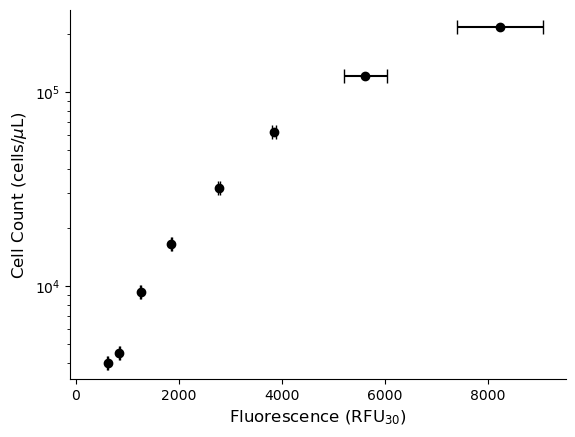

In [8]:
fluor_data = p_ab.od_data_to_dict(p_ab.data)

cmap = mpl.colormaps['viridis']

fluor_data_t = np.zeros((len(row_list)-2,len(col_list)-2))
fluor_data_std = np.zeros((len(row_list)-2,len(col_list)-2))
row_indx = 0
for row in row_list[1:-1]:
    col_indx = 0
    for col in col_list[1:-1]:
        key = row + col
        fluor_data_t[row_indx,col_indx] = fluor_data[key]
        col_indx += 1
    row_indx += 1

fluor_avg = np.mean(fluor_data_t,axis=0)
fluor_err = np.std(fluor_data_t,axis=0)/np.sqrt(len(row_list)-2)

fig,ax = plt.subplots()

ax.errorbar(fluor_avg[1:],cell_count[1:],xerr=fluor_err[1:],fmt='o',capsize=5,color='k')

# ax.set_xscale('log')
ax.set_yscale('log')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Fluorescence (RFU$_{30}$)',fontsize=12)
ax.set_ylabel('Cell Count (cells/$\mu$L)',fontsize=12)

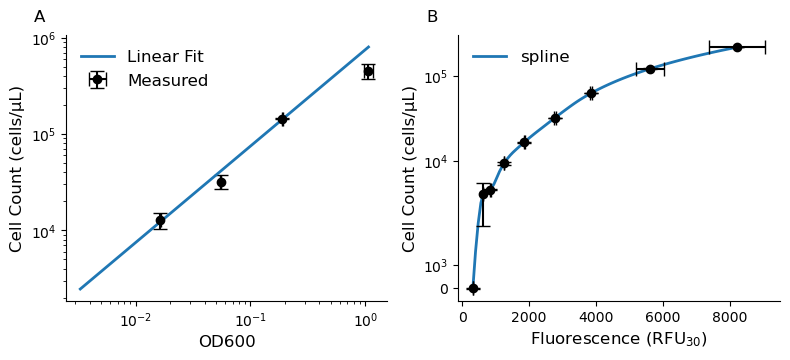

In [9]:
fluor_norm = fluor_data_t/np.max(fluor_data_t)
fluor_norm_avg = np.mean(fluor_norm,axis=0)
fluor_norm_err = np.std(fluor_norm,axis=0)/np.sqrt(len(row_list)-2)

cell_count_norm = cell_count/np.max(cell_count)

# remove first point
fluor_norm_avg = fluor_norm_avg[1:]
fluor_norm_err = fluor_norm_err[1:]

cell_count_norm = cell_count_norm[1:]

s = 0
k = 2

# sort data
sort_indx = np.argsort(fluor_norm_avg)
fluor_norm_avg = fluor_norm_avg[sort_indx]
cell_count_norm = cell_count_norm[sort_indx]

spline = interp.UnivariateSpline(fluor_norm_avg,cell_count_norm,k=k,s=s)
xfit = np.linspace(np.min(fluor_norm_avg),np.max(fluor_norm_avg),100)
yfit = spline(xfit)

fig,ax_list = plt.subplots(ncols=2,figsize=(8,3.5))

ax = ax_list[0]

ax.errorbar(od_measured,cell_count_plate_streak,yerr=cell_count_plate_streak_err,xerr=od_measured_err,
            fmt='o',capsize=5,label='Measured',color='k')
ax.set_yscale('log')
ax.set_xscale('log')

ax.plot(xfit_odvc,yfit_odvc,label='Linear Fit',linewidth=2)

ax.set_xlabel('OD600',fontsize=12)
ax.set_ylabel('Cell Count (cells/μL)',fontsize=12)

ax.legend(fontsize=12,frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax = ax_list[1]

ax.plot(xfit*np.max(fluor_data_t),yfit*np.max(cell_count),label='spline',linewidth=2)

# ax.legend(frameon=False,fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Fluorescence (RFU$_{30}$)',fontsize=12)
ax.set_ylabel('Cell Count (cells/μL)',fontsize=12)
ax.errorbar(fluor_avg[1:],cell_count[1:],xerr=fluor_err[1:],yerr=cell_count_err[1:],fmt='o',capsize=5,color='k')

ax.set_yscale('symlog',linthresh=4000)
# ax.set_xscale('log')
ax.legend(frameon=False,fontsize=12)

fig.tight_layout()

# annotate panels

ax_list[0].annotate('A',xy=(-0.1,1.05),xycoords='axes fraction',fontsize=12)
ax_list[1].annotate('B',xy=(-0.1,1.05),xycoords='axes fraction',fontsize=12)

fig.savefig('../../figures/calibration_figs.pdf',bbox_inches='tight')